[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/witchapong/build-ai-based-applications/blob/main/tabular/5_evaluation.ipynb)

# Stock Price Prediction using ML model
In this session, we'll learn how to build a ML model for predicting **%change of stock prices of the next day** of stocks in SET index (Stock Exchange of Thailand). Thus, we should be able to use the prediction to buy stocks that are going up the next day, make profits, and hopefully get rich!

This session is divided into the following 5 notebooks.
1. `1_collect_data.ipynb`
2. `2_eda.ipynb`
3. `3_features_prep.ipynb`
4. `4_make_prediction.ipynb`
5. `5_evaluation.ipynb` (current notebook)

In [30]:
# # mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [31]:

from pathlib import Path

# running on Colab
DATA_DIR = Path("/content/drive/MyDrive/build-ai-based-applications/")

# # running on local
# DATA_DIR = Path(".")

# Evaluation
In the final step, we'll evaluate the prediction that we generated from our model. We'll do the following
- measure the prediction error
- visualize predicted return vs actual return
- visualize distribution of actual return by predicted return quantile
- measure profitability if we were to use the model for daily trading execution

In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)

# prediction error
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Load and Merge Prediction and Model data

In [33]:
# import prediction
prediction_df = pd.read_csv(DATA_DIR / "data/prediction.csv")

In [34]:
prediction_df.head()

,symbol,date,prediction
0,24CS,2022-10-03,-0.000994
1,24CS,2022-10-04,0.003970
2,24CS,2022-10-05,0.003970
3,24CS,2022-10-06,0.001731
4,24CS,2022-10-07,0.002824


In [35]:
# import model data
usecols = ["symbol", "date", "open", "high", "low", "close", "volume", "r01_fwd"]
data_df = pd.read_csv(DATA_DIR / "data/model_data.csv", usecols=usecols)

In [36]:
data_df.head()

,symbol,date,open,high,low,close,volume,r01_fwd
0,24CS,2022-10-03,7.10,10.20,7.10,10.20,559465900,-0.299020
1,24CS,2022-10-04,10.70,11.10,7.15,7.15,330707400,-0.279720
2,24CS,2022-10-05,5.85,6.45,5.05,5.15,361028900,0.009709
3,24CS,2022-10-06,5.40,5.45,4.70,5.20,232679200,-0.038462
4,24CS,2022-10-07,5.10,5.15,4.76,5.00,131778400,0.000000


In [37]:
# merge prediction with model data
eval_df = data_df.merge(prediction_df, on=["symbol", "date"], how="inner")

In [38]:
eval_df.dropna(inplace=True)

In [39]:
eval_df.head()

,symbol,date,open,high,low,close,volume,r01_fwd,prediction
0,24CS,2022-10-03,7.10,10.20,7.10,10.20,559465900,-0.299020,-0.000994
1,24CS,2022-10-04,10.70,11.10,7.15,7.15,330707400,-0.279720,0.003970
2,24CS,2022-10-05,5.85,6.45,5.05,5.15,361028900,0.009709,0.003970
3,24CS,2022-10-06,5.40,5.45,4.70,5.20,232679200,-0.038462,0.001731
4,24CS,2022-10-07,5.10,5.15,4.76,5.00,131778400,0.000000,0.002824


# Measure Prediction Error
Mean Absolute Error (MAE) and Mean Squared Error (MSE) are two commonly used error measurement metric for regression problem. However, the unit of MSE is the square of the original unit we want to predict and is harder to interpret. Hence, we can use Root Mean Squared Error (RMSE) which further take square root of the squared error term so the original unit is maintained.

In [40]:
print("Mean Absolute Error (MAE):", mean_absolute_error(eval_df["r01_fwd"], eval_df["prediction"]))
print("Mean Squared Error (MSE):", mean_squared_error(eval_df["r01_fwd"], eval_df["prediction"]))
print("Root Mean Squared Error (RMSE):", root_mean_squared_error(eval_df["r01_fwd"], eval_df["prediction"]))

Mean Absolute Error (MAE): 0.015736565045871006
Mean Squared Error (MSE): 0.000827384040630292
Root Mean Squared Error (RMSE): 0.028764284114684516


# Visualize Predicted vs Actual

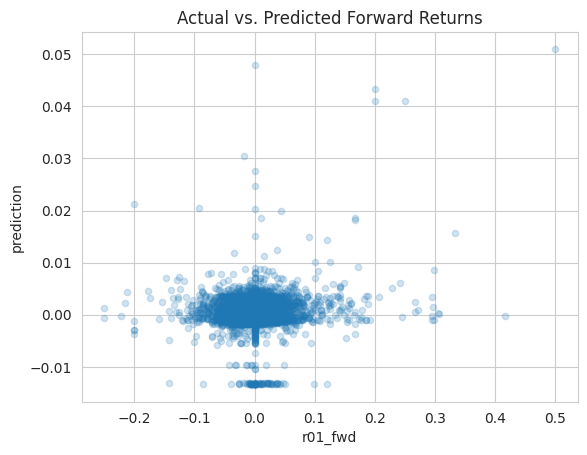

In [41]:
_ = eval_df.sample(10_000).plot.scatter(x="r01_fwd", y="prediction", alpha=0.2)
_ = plt.title("Actual vs. Predicted Forward Returns")

# Visualize Relationship Between Predicted vs Actual
Let's take a look if actual forward returns actually go in the same direction with predicted return.

In [42]:
eval_df["prediction_pct_rnk"] = eval_df.groupby("date")["prediction"].rank(pct=True)

In [43]:
eval_df["prediction_bin"] = pd.cut(eval_df["prediction_pct_rnk"], bins=np.arange(0, 1.1, .2), labels=False)

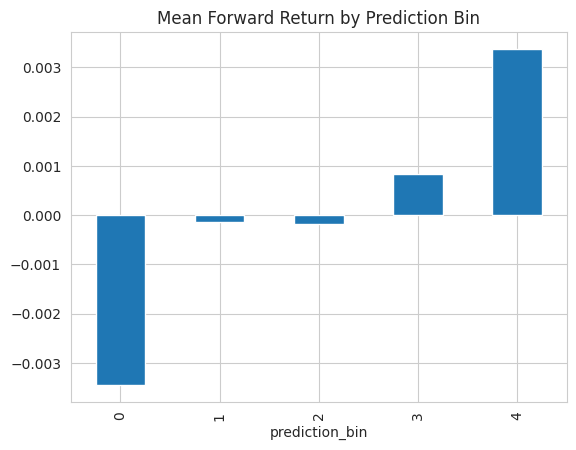

In [44]:
_ = eval_df.groupby("prediction_bin")["r01_fwd"].mean().plot(kind="bar")
_ = plt.title("Mean Forward Return by Prediction Bin")

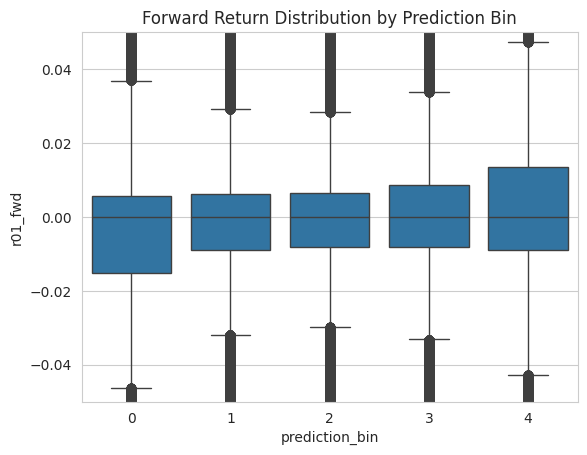

In [45]:
_ = sns.boxplot(data=eval_df, x="prediction_bin", y="r01_fwd")
_ = plt.ylim([-.05, .05])
_ = plt.title("Forward Return Distribution by Prediction Bin")

# Measure Profitability
Finally, we'll measure our model profitability if we were to use our model for buying and selling stocks daily based on the prediction. We'll also compare the profitability with return of SET index.

In [46]:
eval_df = eval_df.set_index(["symbol", "date"]).sort_index()

In [47]:
fwd_returns  = eval_df["r01_fwd"].unstack("symbol")
fwd_returns

symbol,24CS,2S,3BBIF,A,A5,AAI,AAV,ABM,ACAP,ACC,...,WP,WPH,XBIO,XO,XPG,YGG,YONG,YUASA,ZEN,ZIGA
date,,,,,,,,,,,,,,,,,,,,,
2020-12-28,NaN,0.014925,NaN,-0.004000,0.000000,NaN,0.016806,-0.012195,0.106667,0.018182,...,0.000000,-0.005780,0.120000,-0.009615,0.000000,-0.028736,NaN,0.020690,0.000000,0.007143
2020-12-29,NaN,0.029411,NaN,0.004016,0.000000,NaN,-0.024793,0.000000,-0.186747,0.000000,...,-0.004651,0.011628,-0.035714,0.077670,0.000000,0.047337,NaN,0.000000,-0.035398,0.007092
2020-12-30,NaN,0.004762,NaN,0.000000,0.000000,NaN,0.016949,0.012346,-0.029630,0.000000,...,0.004673,-0.005747,-0.037037,0.018018,-0.009345,-0.028249,NaN,0.020270,-0.009174,0.000000
2021-01-04,NaN,-0.004740,NaN,0.000000,0.000000,NaN,0.033333,0.036585,-0.045801,0.000000,...,0.004651,0.011561,-0.038462,0.044248,0.000000,-0.011628,NaN,0.112583,0.009259,0.000000
2021-01-05,NaN,0.009524,NaN,0.000000,0.000000,NaN,0.000000,-0.011764,-0.056000,-0.017857,...,-0.004630,-0.011429,0.000000,0.008475,-0.009436,-0.029412,NaN,-0.053571,0.027523,-0.007042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.006944,-0.007299,0.000000,0.000000,-0.038168,-0.016393,0.000000,0.028037,0.000000,0.033898,...,0.017544,0.000000,0.104167,0.027273,-0.010989,0.018519,-0.018519,0.005051,0.007092,0.006211
2024-12-24,0.000000,-0.007353,0.000000,0.000000,0.039683,0.033333,0.000000,0.009091,0.000000,-0.032787,...,-0.005747,-0.016667,-0.018868,0.004425,-0.011111,0.090909,0.018868,0.005025,0.000000,0.024691
2024-12-25,-0.006897,0.022222,-0.009434,0.000000,0.022901,-0.032258,-0.007407,-0.027027,0.000000,-0.033898,...,0.005780,0.005650,0.038462,-0.008811,0.011236,-0.033333,0.009259,0.000000,-0.014084,0.000000


In [48]:
predictions = eval_df["prediction"].unstack("symbol")
predictions

symbol,24CS,2S,3BBIF,A,A5,AAI,AAV,ABM,ACAP,ACC,...,WP,WPH,XBIO,XO,XPG,YGG,YONG,YUASA,ZEN,ZIGA
date,,,,,,,,,,,,,,,,,,,,,
2020-12-28,NaN,0.001590,NaN,0.001590,0.001590,NaN,0.001749,0.001590,0.001590,0.001749,...,0.001590,0.001590,0.001590,0.001590,0.001590,0.001590,NaN,0.001590,0.001590,0.001749
2020-12-29,NaN,0.001590,NaN,0.001749,0.001749,NaN,0.001590,0.001749,0.001590,0.001590,...,0.001749,0.001749,0.001590,0.001749,0.001749,0.001749,NaN,0.001590,0.001749,0.001590
2020-12-30,NaN,0.001590,NaN,0.001590,0.001590,NaN,0.001749,0.001590,0.015638,0.001590,...,0.001590,0.001590,0.001749,0.001590,0.001590,0.001590,NaN,0.001590,0.001749,0.001590
2021-01-04,NaN,-0.001096,NaN,-0.001096,-0.001096,NaN,-0.001096,-0.001096,-0.000936,-0.001096,...,-0.001096,-0.000936,-0.000936,-0.001096,-0.000936,-0.000936,NaN,-0.001096,-0.000936,-0.001096
2021-01-05,NaN,-0.000936,NaN,-0.000936,-0.000936,NaN,-0.001096,-0.001096,-0.000936,-0.000936,...,-0.001096,-0.001096,-0.000936,-0.001096,-0.000936,-0.000936,NaN,-0.001096,-0.001096,-0.000936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,-0.000899,-0.000811,-0.000502,-0.000811,-0.000899,-0.000899,-0.000759,0.000451,-0.000747,-0.000759,...,-0.000811,-0.000899,0.000438,-0.001804,-0.000899,-0.000243,0.000134,-0.000559,-0.000811,0.000021
2024-12-24,-0.000759,-0.000559,-0.000608,-0.000811,0.000980,0.000324,-0.000559,-0.000066,-0.000608,-0.000243,...,-0.000759,-0.000811,-0.000908,-0.000899,-0.000559,-0.000066,0.001157,-0.000479,-0.000899,0.000021
2024-12-25,-0.000672,-0.000155,-0.000415,-0.000479,-0.000759,-0.000899,-0.000479,-0.000066,-0.000608,0.000324,...,-0.000559,0.000464,0.001108,-0.000811,-0.000559,-0.001804,-0.000066,-0.000672,-0.000698,-0.000066


In [49]:
assert all(fwd_returns.index == predictions.index)
assert all(fwd_returns.columns == predictions.columns)

In [50]:
N_LONG = 50
N_SHORT = 50

long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) <= N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) <= N_SHORT)
                 .astype(int))

In [51]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

In [52]:
set_df = pd.read_csv(DATA_DIR / "data/set_price_index.csv").set_index("Date")
set_return = set_df["Close"].pct_change().to_frame("SET")

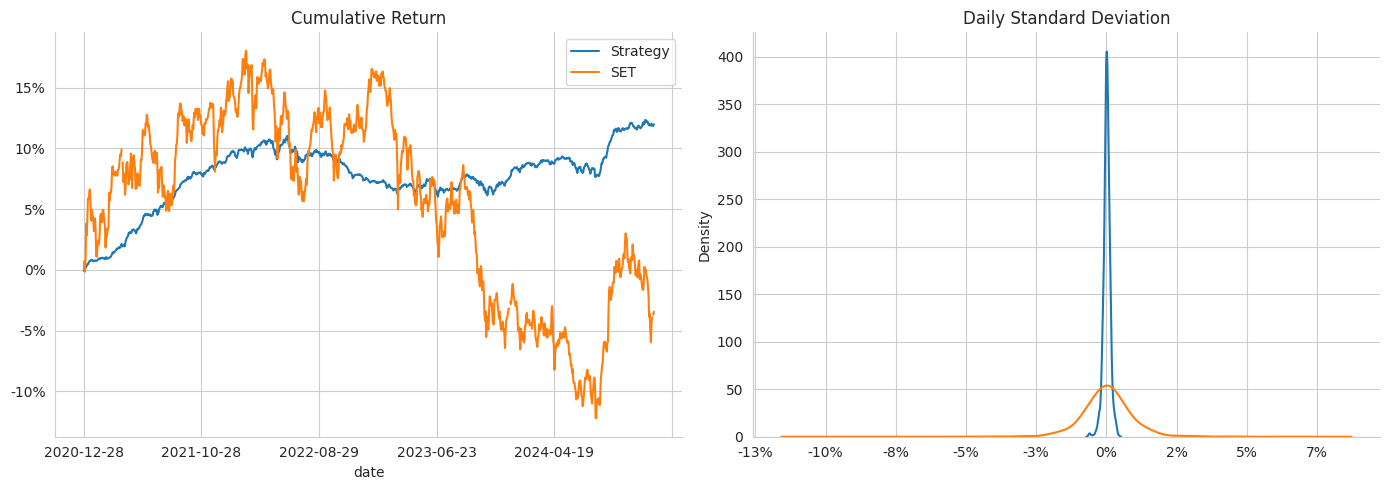

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(set_return).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(set_return, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()

fig.tight_layout()